In [4]:
import numpy as np
import torch
from torch import nn
import torchaudio
import os
# from tqdm.auto import tqdm
# import matplotlib.pyplot as plt
# import math
# import timm
# import soundfile as sf
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, f1_score, classification_report, ConfusionMatrixDisplay

In [3]:
!pip install tqdm

^C
ERROR: Operation cancelled by user


In [5]:
import pandas as pd

# Load the CSV file into a DataFrame
csv_path = "combined_la_data.csv"
df = pd.read_csv(csv_path)

# Replace the base path in the File Path column
old_base_path = "/Users/minsmacbook/Documents/GitHub/ast/asvspoof/archive"
new_base_path = "/home/p510/Downloads/ast/asvspoof/archive"
df["File Path"] = df["File Path"].str.replace(old_base_path, new_base_path)

# Save the updated DataFrame to a new CSV file
updated_csv_path = "updated_combined_la_data.csv"
df.to_csv(updated_csv_path, index=False)

print(f"Updated CSV saved to {updated_csv_path}")

Updated CSV saved to updated_combined_la_data.csv


In [4]:
print(os.getcwd())

/Users/minsmacbook/Documents/GitHub/ast/asvspoof


In [6]:
train_audio_files_path = '/Users/minsmacbook/Documents/GitHub/ast/asvspoof/LA/ASVspoof2019_LA_train/flac'
train_labels_path = '/Users/minsmacbook/Documents/GitHub/ast/asvspoof/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
val_audio_files_path = '/Users/minsmacbook/Documents/GitHub/ast/asvspoof/LA/ASVspoof2019_LA_dev/flac'
val_labels_path = '/Users/minsmacbook/Documents/GitHub/ast/asvspoof/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt'
len(os.listdir(train_audio_files_path))
len(os.listdir(val_audio_files_path))

24986

In [8]:
def readtxtfile(path):
    with open(path, 'r') as file:
        text = file.read().splitlines()
        return text
    
def getlabels(path):
    text = readtxtfile(path)
    filename2label = {}
    for item in tqdm(text):
        key = item.split(' ')[1]
        value = item.split(' ')[-1]
        filename2label[key] = value
        
    return filename2label

In [59]:
filename2label = getlabels(train_labels_path)
val_filename2label = getlabels(val_labels_path)
print(len(filename2label))

  0%|          | 0/25380 [00:00<?, ?it/s]

  0%|          | 0/24844 [00:00<?, ?it/s]

25380


2580 22800


(array([ 2580.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 22800.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

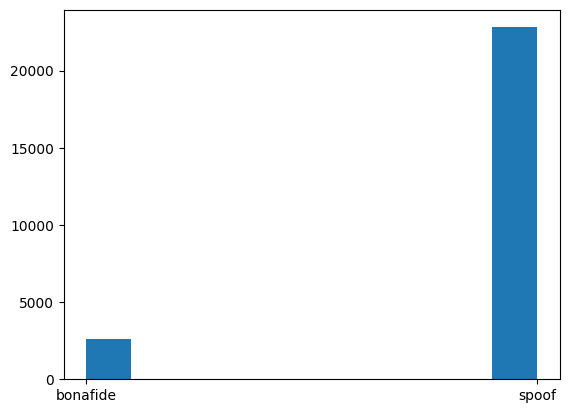

In [15]:
l = list(filename2label.values())
print(l.count('bonafide'), l.count('spoof'))
plt.hist(l)

In [55]:
spoof1 = os.listdir(train_audio_files_path)[0]
spoof2 = os.listdir(train_audio_files_path)[1]
bonafide1 = os.listdir(train_audio_files_path)[100]
bonafide2 = 'LA_T_1138215.flac'
bonafide3 = 'LA_T_1271820.flac'

# Path to your .flac file
spoof_file1 = train_audio_files_path + '/' + spoof1
spoof_file2 = train_audio_files_path + '/' + spoof2
bonafide_file1 = train_audio_files_path + '/' + bonafide1
bonafide_file2 = train_audio_files_path + '/' + bonafide2
bonafide_file3 = train_audio_files_path + '/' + bonafide3



In [57]:
example = os.listdir(train_audio_files_path)[1].split('.')[0]
print(example)
filename2label[example]

LA_T_9203016


'spoof'

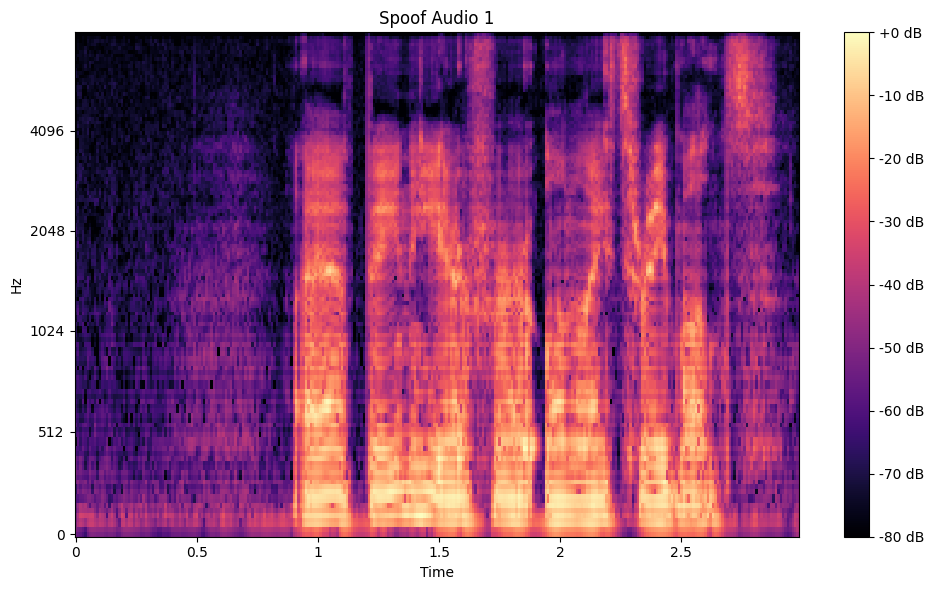

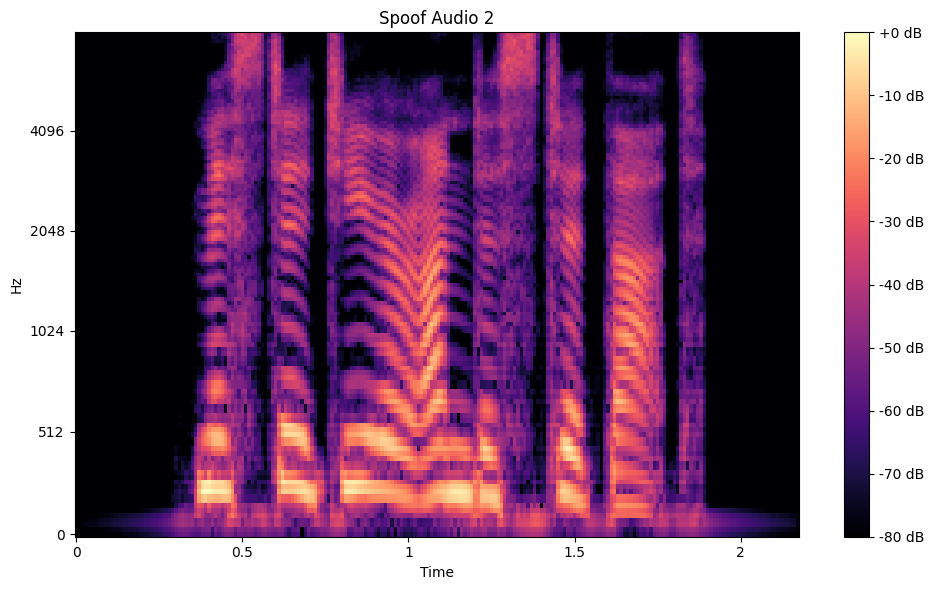

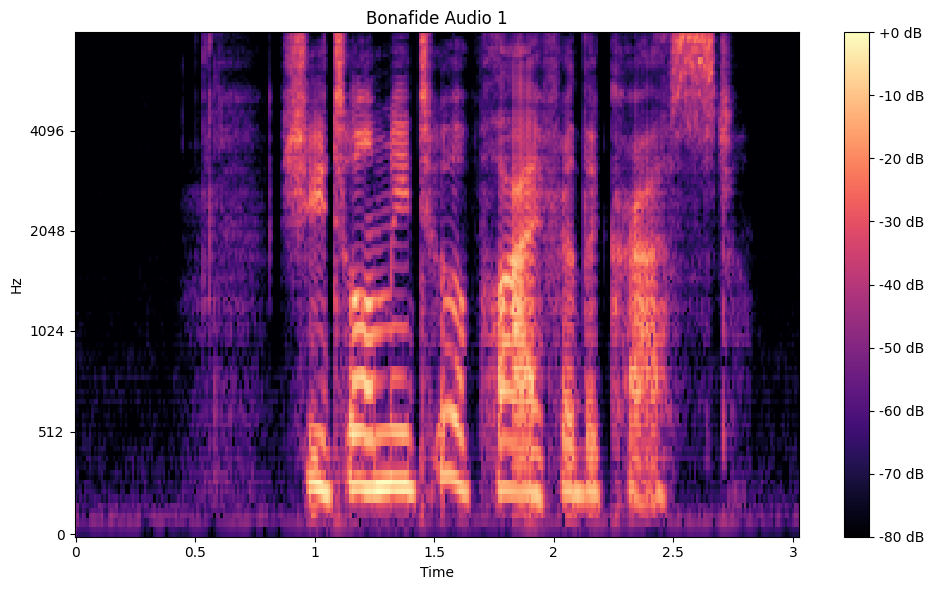

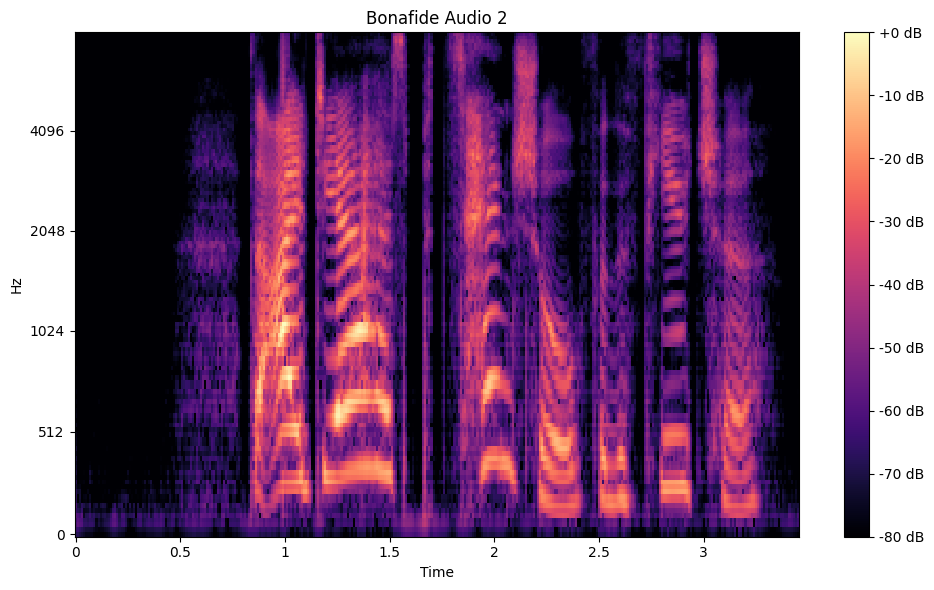

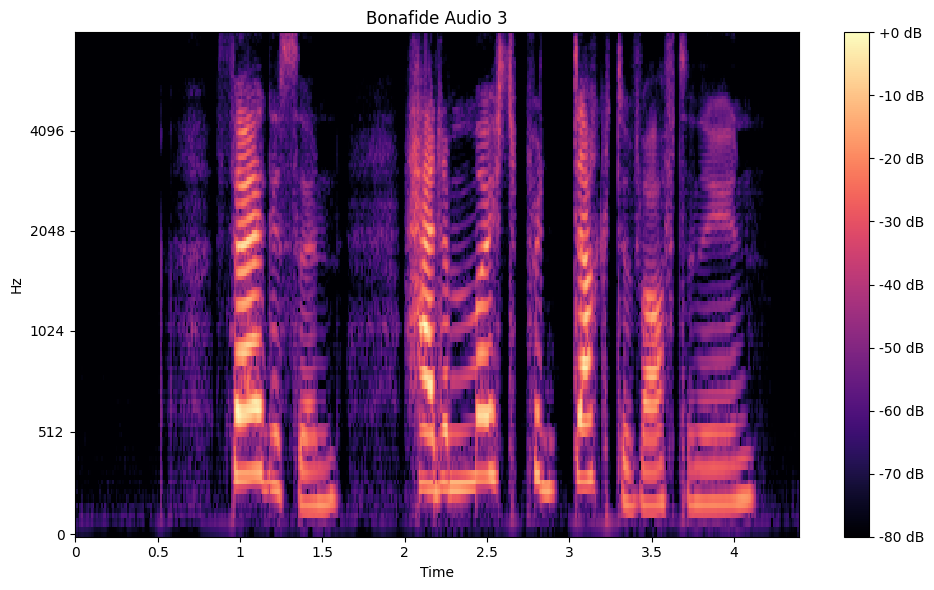

In [58]:
import librosa
import numpy as np

# Load the .flac file
def load_audio(file_path, sample_rate=16000):
    audio_data, sr = librosa.load(file_path, sr=sample_rate)
    return audio_data, sr

# Generate the 128-dimensional log Mel filterbank features (fbank)
def generate_mel_spectrogram(audio_data, sample_rate, n_fft=400, hop_length=160, n_mels=128):
    # n_fft=400 corresponds to 25ms (0.025s) window length at a 16kHz sampling rate
    # hop_length=160 corresponds to 10ms (0.01s) hop length at a 16kHz sampling rate
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio_data,
        sr=sample_rate,
        n_fft=n_fft,  # 25ms window
        hop_length=hop_length,  # 10ms hop length
        n_mels=n_mels  # 128 Mel bands
    )
    return mel_spectrogram

# Convert Mel-spectrogram to log scale (log Mel-spectrogram)
def log_mel_spectrogram(mel_spectrogram):
    log_mel = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to log scale
    return log_mel

# Normalize the log Mel-spectrogram so that mean=0 and std=0.5
def normalize_spectrogram(spectrogram):
    mean = np.mean(spectrogram)
    std = np.std(spectrogram)
    
    normalized_spectrogram = (spectrogram - mean) / std
    
    normalized_spectrogram = normalized_spectrogram * 0.5
    
    return normalized_spectrogram


# Function to plot the log Mel-spectrogram
def plot_spectrogram(log_mel_spectrogram, sample_rate, hop_length, title):
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(log_mel_spectrogram, 
                             sr=sample_rate, 
                             hop_length=hop_length, 
                             x_axis='time', 
                             y_axis='mel', 
                             fmax=sample_rate // 2)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Convert the spectrogram to the shape expected by AST

# AST expects the shape to be (num_channels, time, frequency), where num_channels = 1 (for mono audio)
def reshape_spectrogram(spectrogram):
    return np.expand_dims(spectrogram, axis=0)  # Add channel dimension (1, time, frequency)


#main function
def preprocess_for_ast(file_path, title):
    # Load the audio
    audio_data, sample_rate = load_audio(file_path)

    # Generate Mel-spectrogram with 25ms window and 10ms hop length
    mel_spectrogram = generate_mel_spectrogram(audio_data, sample_rate)

    # Convert Mel-spectrogram to log scale
    log_mel = log_mel_spectrogram(mel_spectrogram)

    # Normalize the spectrogram
    normalized_spectrogram = normalize_spectrogram(log_mel)

    # Plot the log Mel-spectrogram
    plot_spectrogram(log_mel, sample_rate, hop_length=160, title=title)

    # Reshape for AST input
    ast_input = reshape_spectrogram(normalized_spectrogram)

    return ast_input

spoof_input1 = preprocess_for_ast(spoof_file1, title='Spoof Audio 1')
spoof_input2 = preprocess_for_ast(spoof_file2, title='Spoof Audio 2')
bonafide_input1 = preprocess_for_ast(bonafide_file1, title='Bonafide Audio 1')
bonafide_input2 = preprocess_for_ast(bonafide_file2, title='Bonafide Audio 2')
bonafide_input3 = preprocess_for_ast(bonafide_file3, title = 'Bonafide Audio 3')


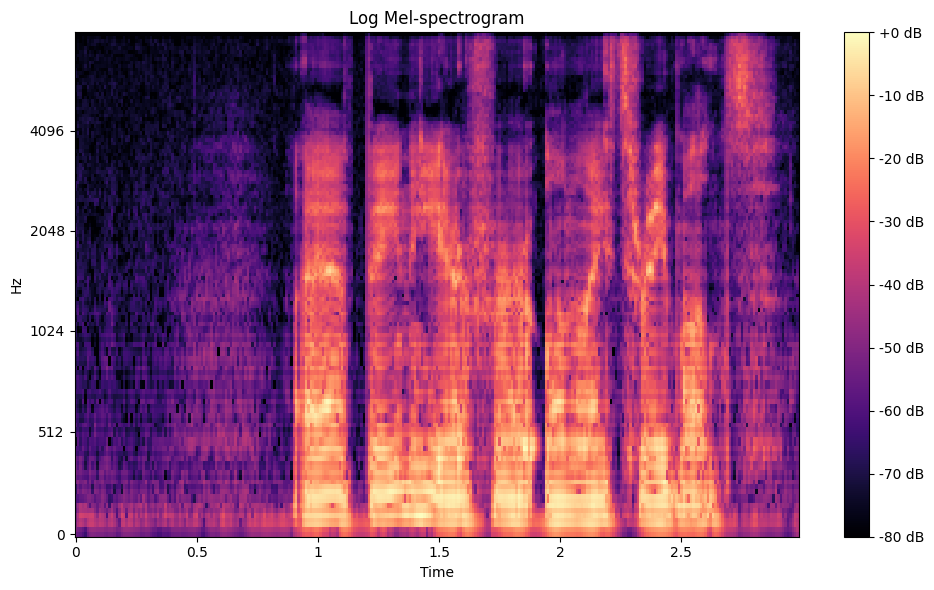

In [27]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the .flac file
def load_audio(file_path, sample_rate=16000):
    audio_data, sr = librosa.load(file_path, sr=sample_rate)
    return audio_data, sr

# Generate the 128-dimensional log Mel filterbank features (fbank)
def generate_mel_spectrogram(audio_data, sample_rate, n_fft=400, hop_length=160, n_mels=128):
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio_data,
        sr=sample_rate,
        n_fft=n_fft,  # 25ms window length
        hop_length=hop_length,  # 10ms hop length
        n_mels=n_mels  # 128 Mel bands
    )
    return mel_spectrogram

# Convert Mel-spectrogram to log scale (log Mel-spectrogram)
def log_mel_spectrogram(mel_spectrogram):
    log_mel = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to log scale
    return log_mel

# Function to plot the log Mel-spectrogram
def plot_spectrogram(log_mel_spectrogram, sample_rate, hop_length, title="Log Mel-spectrogram"):
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(log_mel_spectrogram, 
                             sr=sample_rate, 
                             hop_length=hop_length, 
                             x_axis='time', 
                             y_axis='mel', 
                             fmax=sample_rate // 2)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Main function to preprocess audio and plot spectrogram
def preprocess_and_plot(file_path):
    # Load the audio
    audio_data, sample_rate = load_audio(file_path)

    # Generate Mel-spectrogram with 25ms window and 10ms hop length
    mel_spectrogram = generate_mel_spectrogram(audio_data, sample_rate)

    # Convert Mel-spectrogram to log scale
    log_mel = log_mel_spectrogram(mel_spectrogram)

    # Plot the log Mel-spectrogram
    plot_spectrogram(log_mel, sample_rate, hop_length=160)

# Example usage
file_path = flac_file
preprocess_and_plot(file_path)

In [2]:
import pandas as pd

# Paths to the two CSV files
base = os.getcwd()
print(base)
csv_file_1 = base + "/combined_df_data.csv"
csv_file_2 = base + "/combined_la_data.csv"
print(csv_file_1)

# Load both CSV files into dataframes
df1 = pd.read_csv(csv_file_1)
df2 = pd.read_csv(csv_file_2)

# Merge the two dataframes
merged_df = pd.concat([df1, df2], ignore_index=True)

# Save the merged dataframe to a new CSV file
output_csv = base + "/merged_deepfake.csv"
merged_df.to_csv(output_csv, index=False)

print(f"Merged CSV saved to {output_csv}")

/Users/minsmacbook/Documents/GitHub/ast/egs/asvspoof2021
/Users/minsmacbook/Documents/GitHub/ast/egs/asvspoof2021/combined_df_data.csv
Merged CSV saved to /Users/minsmacbook/Documents/GitHub/ast/egs/asvspoof2021/merged_deepfake.csv
